In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm


import seaborn as sns
sns.set(style="ticks")
from scipy.optimize import curve_fit
import os
import numpy as np
import glob
import scipy as sc
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

In [2]:
from scipy import stats

def linearRegression(df):
    x = df[df.DiscoveryTime.notnull()].trialNum.values
    y = df[df.DiscoveryTime.notnull()].DiscoveryTime.values

    slope, intercept, r_value, p_value, std_err = sc.stats.linregress(x, y)
    
    return(slope, intercept, r_value, p_value, std_err)

In [3]:
# Define exponential function func,  
# where a = alpha, b = Tau, c = y intercept

def fit_to_exponential(x, a, b, c):
     return a * np.exp(-(x / b)) + c

# Individual floral shape

In [4]:
direc = r'E:\Downloads\ManducaMultiSenseData\v3\Step5_v3'

outpath = r'E:\Downloads\ManducaMultiSenseData\v3\Step6_v3'
outpath_fig = r'E:\Downloads\ManducaMultiSenseData\v3\Step6_v3\Figure'

Save the all shape specific files as a single file

In [5]:
Lightlevel = ['L0.1', 'L50']


for Lightlevel in Lightlevel:
    
    Light_specific_file = glob.glob(direc + "\\" + Lightlevel + '*Raw*.csv')
       
    # get the data together and save as single dataset
    
    df1=[]
    df2=[]
    df3=[]
    df4=[]
    df5=[]
    df6=[]

    ctr = 0
    for fpath in Light_specific_file:
        df = pd.read_csv(fpath)
        DiscoveryTime = df['DiscoveryTime']
        trialNum= df.index
        
#         fname = os.path.basename(fpath)[:-30]
        a,b, c, _ = os.path.basename(fpath).split("_")
        fname = a + "_" + b + "_" + c
        
        names = [fname]*len(trialNum)
        
        mothIn = df['In_Frame']
        mothOut = df['Out_Frame']
        Proboscis = df['ProboscisDetect']

        df1.extend(DiscoveryTime)
        df2.extend(trialNum)
        df3.extend(names)
        df4.extend(mothIn)
        df5.extend(mothOut)
        df6.extend(Proboscis)
        ctr+=1
        print(ctr)

    new_df = (pd.DataFrame({'In_Frame' : df4, 'Out_Frame' : df5, 'Proboscis' : df6,
                            'DiscoveryTime': df1, 'trialNum': df2, 'name' : df3}))
    print(Lightlevel + '\t' + "has a total of" + '\t'+ str(ctr) + '\t' + "moths")
    new_df.to_csv(outpath + "\\" + Lightlevel + "Allmoths.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
L0.1	has a total of	29	moths
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
L50	has a total of	26	moths


In [6]:
dFrame = pd.DataFrame()

file = glob.glob(outpath + "\\" + '*Allmoths.csv')

for f in file:
    print(f)
    df = pd.read_csv(f)
    dFrame = dFrame.append(df)
dFrame.to_csv(outpath  + "\\" + "AllLight_EveryMoth.csv")

E:\Downloads\ManducaMultiSenseData\v3\Step6_v3\L0.1Allmoths.csv
E:\Downloads\ManducaMultiSenseData\v3\Step6_v3\L50Allmoths.csv


Fit to curve and plot

No handles with labels found to put in legend.


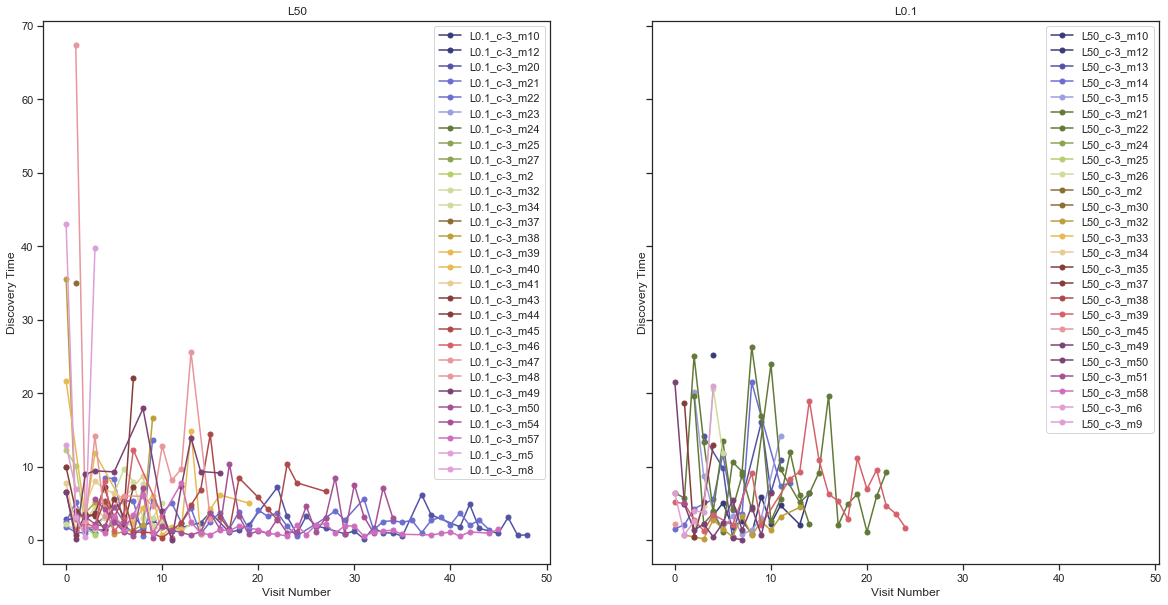

In [7]:
f, ax = plt.subplots(1,2, figsize = (20,10), sharex = True, sharey = True)
for idx, f in enumerate(file):
    df = pd.read_csv(f)
    names = df.name.unique()
    n = len(names)
    color = cm.tab20b(np.linspace(0,1,n))
    
    for name, c in zip(names, color):
        x = dFrame[(dFrame.name == name) & (dFrame.DiscoveryTime.notnull())].trialNum
        y = dFrame[(dFrame.name == name) & (dFrame.DiscoveryTime.notnull())].DiscoveryTime
        ax[idx].plot(x, y/100, 'o-', markersize = 5, label = name, color = c)
        
        ax[idx].set_ylabel('Discovery Time')
        ax[idx].set_xlabel('Visit Number')

    ax[0].set_title('L50')
    ax[1].set_title('L0.1')
    ax[0].legend()
    ax[1].legend()

plt.savefig(outpath_fig + 'individualMoth_learningCurve.png')

['E:\\Downloads\\ManducaMultiSenseData\\v3\\Step6_v3\\L0.1Allmoths.csv']
['E:\\Downloads\\ManducaMultiSenseData\\v3\\Step6_v3\\L50Allmoths.csv']


C:\Users\guess\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


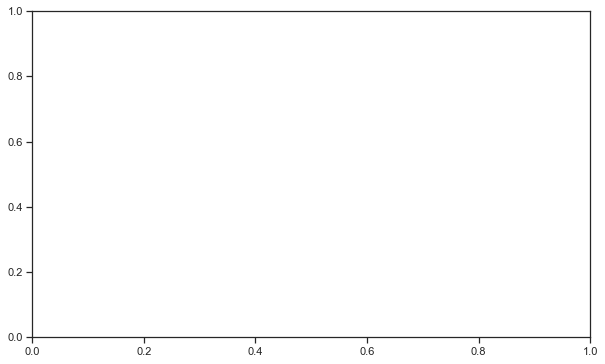

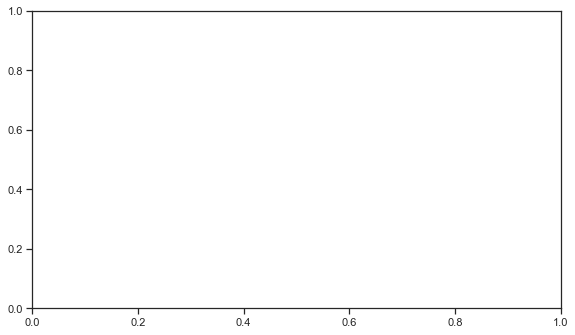

In [8]:
# do the fit for three different y0 - computed across different lengths of the saturation - curve
Lightlevel = ['L0.1','L50']
fig1, ax0 = plt.subplots(figsize = (10,6))
fig2, ax1 = plt.subplots(figsize = (10,6))

for Lightlevel in Lightlevel:
    
    file  = glob.glob(outpath + "\\" + Lightlevel + 'Allmoths.csv')
    print(file)

    new_df = pd.read_csv(file[0])
    
    xdata = new_df.trialNum.values
    ydata = new_df.DiscoveryTime.values
    
    xdata_notnan = new_df[new_df.DiscoveryTime.notnull()].trialNum.values
    ydata_notnan = new_df[new_df.DiscoveryTime.notnull()].DiscoveryTime.values
    
    numMoth = len(new_df.name.unique())
    
    length_to_estimate_y0 = [2,4,8]

    # initialize all the variables you want to save
    slope = []
    std_err = []
    p_value = []
    r_value = []
    y_intercept = []
    y_intercept_std_dev = []
    average_firstTrial = []
    alpha = []
    tau= []
    covariance = []

    for length in length_to_estimate_y0:
        totalTrial = max(new_df.trialNum)
        part_of_df = new_df[new_df.trialNum >= (totalTrial * (1-1/length))]
        x = part_of_df[part_of_df.DiscoveryTime.notnull()].trialNum.values
        y = part_of_df[part_of_df.DiscoveryTime.notnull()].DiscoveryTime.values
        m, y0, r_val, p_val, se = linearRegression(part_of_df)

        mean_y0 = part_of_df.DiscoveryTime.mean()
        std_y0 = part_of_df.DiscoveryTime.std()
        mean_a0andy0 = new_df[new_df.trialNum==0].DiscoveryTime.mean()
        a0 = mean_a0andy0 - mean_y0

        # plot the regression line
        x = part_of_df.trialNum
        y = part_of_df.DiscoveryTime
        ax0.plot(x,y*1/100, 'ob', markersize=5, alpha=.5, label = 'Raw data')
        test_x = range(min(x)-5, max(x)+5)
        ax0.plot(test_x, (m*test_x + y0)*1/100, label = 'Fitted line')
        ax0.fill_between(test_x, ((m-se)*test_x + y0)*1/100, ((m+se)*test_x + y0)*1/100, alpha=0.2)
        ax0.set_title(Lightlevel + '_1/' + str(length) + '_lengthData')
        ax0.legend()
        fig1.savefig(outpath_fig + "\\" + Lightlevel + '_1-' + str(length) + '_LinearRegression.svg')
        ax0.cla()

        slope.append(m/100)
        std_err.append(se/100)
        p_value.append(p_val)
        r_value.append(r_val)
        y_intercept.append(mean_y0/100)
        y_intercept_std_dev.append(std_y0/100)
        average_firstTrial.append(mean_a0andy0/100)
        alpha.append(a0/100)
        
        
        popt,pcov = curve_fit(lambda x, b: fit_to_exponential(x, a0, b, mean_y0), xdata_notnan, ydata_notnan)
        tau.append(popt[0]/100)
        covariance.append(pcov.flatten()[0])

        # plot the final curve fit
        max_trial=max(xdata)
        ax1.plot(xdata, ydata*1/100, 'or', markersize=7, alpha=.5, label = 'Raw data')
        ax1.plot(range(0,max_trial), fit_to_exponential(range(0,max_trial), a0, *popt, mean_y0)*1/100, 
                 'g--', linewidth=2, 
                 label = 'fit: alpha= %5.3f , Tau= %5.3f, y0= %5.3f' %(a0/100, popt/100, mean_y0/100))

        ax1.set_title(Lightlevel + '_1-' + str(length) + '_length', y=1.2)
        ax1.set_xlabel('Trial number')
        ax1.set_ylabel('Exploration Time (second)')
        leg = plt.legend()
        leg.get_frame().set_linewidth(1.5)
        ax1.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc=3, mode="expand", borderaxespad=0.)
        ax1.set_xlim([-5,50])
        ax1.set_ylim([-5,70])
        ax1.text(60, 40, 'N= ' + str(numMoth))
        fig2.tight_layout()
        fig2.savefig(outpath_fig + "\\" + 'LearningCurve_' + Lightlevel + '_1-' + str(length) + '_length.svg')
        ax1.cla()

    all_param_df = pd.DataFrame({'slope':slope, 'std_err':std_err,
                                 'p_value':p_value, 'r_value':r_value,
                                 'y_intercept':y_intercept,
                                 'y_intercept_std' : y_intercept_std_dev,
                                 'average_firstTrial':average_firstTrial,
                                 'alpha':alpha,'tau':tau,
                                 'covariance':covariance}, 
                                index = ['one-half', 'last fourth', 'last eight'])
    all_param_df.to_csv(outpath + "\\" + Lightlevel + '_FittedParameters.csv')

## Without Outliers

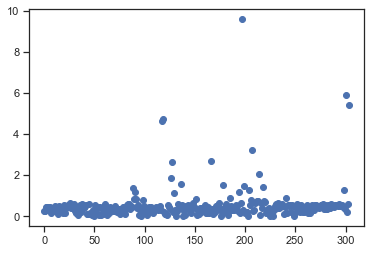

In [9]:
L01Data = pd.read_csv(outpath + "\\L0.1Allmoths.csv")
L01Data = L01Data[L01Data.DiscoveryTime.notnull()]
z = np.abs(stats.zscore(L01Data.DiscoveryTime.values))
outlier_ID = z > 4
plt.plot(z, 'o') 

L01Data['zscore'] = z
L01Data['outlier_ID'] = outlier_ID
L01Data['condition'] = ['Low']*len(z)
notoutliers_01 = L01Data[L01Data.outlier_ID == False]
notoutliers_01.to_csv(outpath + "\\L0.1Allmoths_notoutliers.csv")

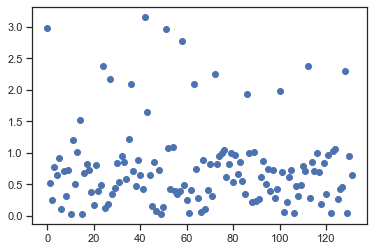

In [10]:
L50Data = pd.read_csv(outpath + "\\L50Allmoths.csv")
L50Data = L50Data[L50Data.DiscoveryTime.notnull()]
z = np.abs(stats.zscore(L50Data.DiscoveryTime.values))
outlier_ID = z > 4
plt.plot(z, 'o') 

L50Data['zscore'] = z
L50Data['outlier_ID'] = outlier_ID
L50Data['condition'] = ['High']*len(z)
notoutliers_50 = L50Data[L50Data.outlier_ID == False]
notoutliers_50.to_csv(outpath + "\\L50Allmoths_notoutliers.csv")

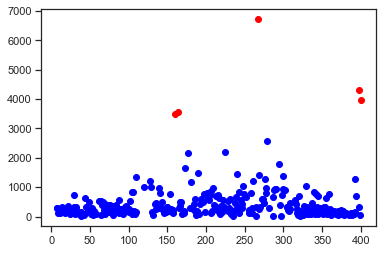

In [11]:
plt.plot(L01Data.DiscoveryTime[L01Data.outlier_ID == True], 'o', color = 'red')
plt.plot(L01Data.DiscoveryTime[L01Data.outlier_ID == False], 'o', color = 'blue')
notoutliers = L01Data[L01Data.outlier_ID == False]

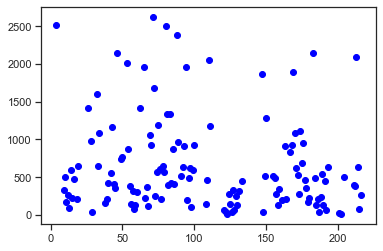

In [12]:
plt.plot(L50Data.DiscoveryTime[L50Data.outlier_ID == True], 'o', color = 'red')
plt.plot(L50Data.DiscoveryTime[L50Data.outlier_ID == False], 'o', color = 'blue')
notoutliers = L50Data[L50Data.outlier_ID == False]

['E:\\Downloads\\ManducaMultiSenseData\\v3\\Step6_v3\\L0.1Allmoths_notoutliers.csv']
['E:\\Downloads\\ManducaMultiSenseData\\v3\\Step6_v3\\L50Allmoths_notoutliers.csv']


C:\Users\guess\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


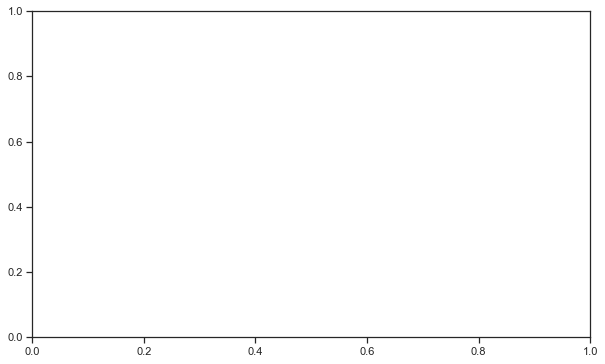

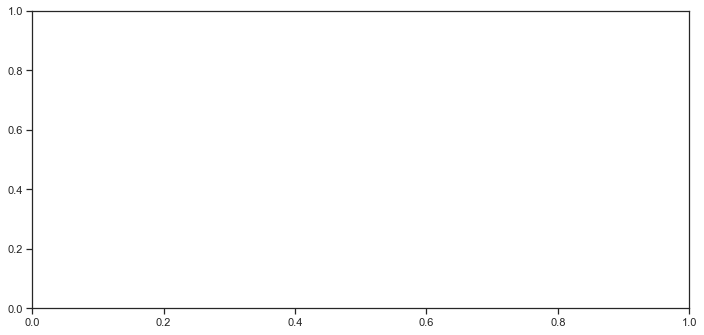

In [13]:
# do the fit for three different y0 - computed across different lengths of the saturation - curve
Lightlevel = ['L0.1','L50']
fig1, ax0 = plt.subplots(figsize = (10,6))
fig2, ax1 = plt.subplots(figsize = (10,6))

for Lightlevel in Lightlevel:
    
    file  = glob.glob(outpath + "\\" + Lightlevel + 'Allmoths_notoutliers.csv')
    print(file)

    new_df = pd.read_csv(file[0])
    
    xdata = new_df.trialNum.values
    ydata = new_df.DiscoveryTime.values
    
    xdata_notnan = new_df[new_df.DiscoveryTime.notnull()].trialNum.values
    ydata_notnan = new_df[new_df.DiscoveryTime.notnull()].DiscoveryTime.values
    
    numMoth = len(new_df.name.unique())
    
    length_to_estimate_y0 = [2,4,8]

    # initialize all the variables you want to save
    slope = []
    std_err = []
    p_value = []
    r_value = []
    y_intercept = []
    y_intercept_std_dev = []
    average_firstTrial = []
    alpha = []
    tau= []
    covariance = []

    for length in length_to_estimate_y0:
        totalTrial = max(new_df.trialNum)
        part_of_df = new_df[new_df.trialNum >= (totalTrial * (1-1/length))]
        x = part_of_df[part_of_df.DiscoveryTime.notnull()].trialNum.values
        y = part_of_df[part_of_df.DiscoveryTime.notnull()].DiscoveryTime.values
        m, y0, r_val, p_val, se = linearRegression(part_of_df)

        mean_y0 = part_of_df.DiscoveryTime.mean()
        std_y0 = part_of_df.DiscoveryTime.std()
        mean_a0andy0 = new_df[new_df.trialNum==0].DiscoveryTime.mean()
        a0 = mean_a0andy0 - mean_y0

        # plot the regression line
        x = part_of_df.trialNum
        y = part_of_df.DiscoveryTime
        ax0.plot(x,y*1/100, 'ob', markersize=5, alpha=.5, label = 'Raw data')
        test_x = range(min(x)-5, max(x)+5)
        ax0.plot(test_x, (m*test_x + y0)*1/100, label = 'Fitted line')
        ax0.fill_between(test_x, ((m-se)*test_x + y0)*1/100, ((m+se)*test_x + y0)*1/100, alpha=0.2)
        ax0.set_title(Lightlevel + '_1/' + str(length) + '_lengthData')
        ax0.legend()
        fig1.savefig(outpath_fig + "//"+ Lightlevel + '_1-' + str(length) + '_LinearRegression_NoOutlier.svg')
        ax0.cla()

        slope.append(m/100)
        std_err.append(se/100)
        p_value.append(p_val)
        r_value.append(r_val)
        y_intercept.append(mean_y0/100)
        y_intercept_std_dev.append(std_y0/100)
        average_firstTrial.append(mean_a0andy0/100)
        alpha.append(a0/100)
        
        
        popt,pcov = curve_fit(lambda x, b: fit_to_exponential(x, a0, b, mean_y0), xdata_notnan, ydata_notnan)
        tau.append(popt[0]/100)
        covariance.append(pcov.flatten()[0])

        # plot the final curve fit
        max_trial=max(xdata)
        ax1.plot(xdata, ydata*1/100, 'or', markersize=7, alpha=.5, label = 'Raw data')
        ax1.plot(range(0,max_trial), fit_to_exponential(range(0,max_trial), a0, *popt, mean_y0)*1/100, 
                 'g--', linewidth=2, 
                 label = 'fit: alpha= %5.3f , Tau= %5.3f, y0= %5.3f' %(a0/100, popt/100, mean_y0/100))

        ax1.set_title(Lightlevel + '_1-' + str(length) + '_length', y=1.2)
        ax1.set_xlabel('Trial number')
        ax1.set_ylabel('Exploration Time (second)')
        leg = plt.legend()
        leg.get_frame().set_linewidth(1.5)
        ax1.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc=3, mode="expand", borderaxespad=0.)
        ax1.set_xlim([-5,90])
        ax1.set_ylim([-5,55])
        ax1.text(60, 40, 'N= ' + str(numMoth))
        fig2.tight_layout()
        fig2.savefig(outpath_fig + "\\" + 'LearningCurve_' + Lightlevel + '_1-' + str(length) + '_length_NotOutlier.svg')
        ax1.cla()

    all_param_df = pd.DataFrame({'slope':slope, 'std_err':std_err,
                                 'p_value':p_value, 'r_value':r_value,
                                 'y_intercept':y_intercept,
                                 'y_intercept_std' : y_intercept_std_dev,
                                 'average_firstTrial':average_firstTrial,
                                 'alpha':alpha,'tau':tau,
                                 'covariance':covariance}, 
                                index = ['one-half', 'last fourth', 'last eight'])
    all_param_df.to_csv(outpath + "\\" + Lightlevel + '_FittedParameters_notOutliers.csv')